In [136]:
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import holidays
from datetime import date
from pvlib.location import Location

In [137]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test.head()
sample_submission = pd.read_csv('sample_submission.csv')

len(train)

88712

In [138]:
# convert to date time
train['datetime'] = pd.to_datetime(train.time, infer_datetime_format=True)
test['datetime'] = pd.to_datetime(test.time, infer_datetime_format=True)

# Remove time as string
train.drop(columns='time',inplace=True)
test.drop(columns='time', inplace=True)

# time in local as datetime format
train['time_local'] = train['datetime'].copy()
test['time_local'] = test['datetime'].copy()

In [139]:
# ToDo @Jonas: time local and utc
train.set_index('datetime', inplace=True)
train['hour'] = train.index.hour
train['day'] = train.index.day
train['month'] = train.index.month

test.set_index('datetime', inplace=True)
test['hour'] = test.index.hour
test['day'] = test.index.day
test['month'] = test.index.month


## check whether its a weekday or a weekend
# monday is 0
# sunday = 6
train['weekday'] = train.index.weekday
test['weekday'] = test.index.weekday
train['weekday'] = train['weekday'].apply(lambda x: 1 if x <= 4 else 0)
test['weekday'] = test['weekday'].apply(lambda x: 1 if x <= 4 else 0)


### Holidays
# ToDo: Brückentage
hessen_holidays = holidays.country_holidays('DE', subdiv='HE')

# date(2015, 1, 1) in hessen_holidays  # True
# date(2015, 1, 2) in hessen_holidays  # False
# train.index[0] in hessen_holidays

time = train.index.copy()
holidayOrNot = []
for itime in time:
    holidayOrNot.append(itime in hessen_holidays)

train['public_holidays'] = holidayOrNot
train['public_holidays'] = train['public_holidays'].apply(lambda x: 1 if x == True else 0)

## do the same for test
time = test.index.copy()
holidayOrNot = []
for itime in time:
    holidayOrNot.append(itime in hessen_holidays)

test['public_holidays'] = holidayOrNot
test['public_holidays'] = test['public_holidays'].apply(lambda x: 1 if x == True else 0)


In [140]:
time = train.index.copy()
dayOfYearCos = []
dayOfYearSin = []
doy = []
for itime in time:
    doy.append(itime.timetuple().tm_yday)
    dayOfYearCos.append(np.cos(itime.timetuple().tm_yday/365*2*np.pi))
    dayOfYearSin.append(np.sin(itime.timetuple().tm_yday/365*2*np.pi))

train['dayOfYearSinosoid'] = dayOfYearSin
train['dayOfYearCosine'] = dayOfYearCos
train['monthSinosoid'] = np.sin(train['month']/12*2*np.pi)
train['monthCosine'] = np.cos(train['month']/12*2*np.pi)
train['hourSinosoid'] = np.sin(train['hour']/24*2*np.pi)
train['hourCosine'] = np.cos(train['hour']/24*2*np.pi)

In [141]:
## Same for Test
time = test.index.copy()
dayOfYearCos = []
dayOfYearSin = []
doy = []

for itime in time:
    doy.append(itime.timetuple().tm_yday)
    dayOfYearCos.append(np.cos(itime.timetuple().tm_yday/365*2*np.pi))
    dayOfYearSin.append(np.sin(itime.timetuple().tm_yday/365*2*np.pi))

test['dayOfYearSinosoid'] = dayOfYearSin
test['dayOfYearCosine'] = dayOfYearCos
test['monthSinosoid'] = np.sin(test['month']/12*2*np.pi)
test['monthCosine'] = np.cos(test['month']/12*2*np.pi)
test['hourSinosoid'] = np.sin(test['hour']/24*2*np.pi)
test['hourCosine'] = np.cos(test['hour']/24*2*np.pi)


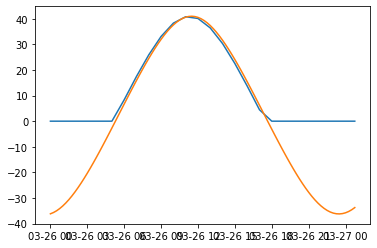

In [142]:
#azimuth and solarHeight in UTC
#site = Location(51.31589123669711, 9.427936780578166, 'CET')
site = Location(51.316, 9.428, 'UTC')
#site = Location(51, 10, 'UTC')
# Definition of a time range of simulation
# train
times = train.index

# Estimate Solar Position with the 'Location' object
solpos = site.get_solarposition(times)
train['AzimuthUTC'] = solpos.azimuth
train['SolarHeightUTC'] = solpos.elevation
#
# test
times = test.index
solpos = site.get_solarposition(times)
test['AzimuthUTC'] = solpos.azimuth
test['SolarHeightUTC'] = solpos.elevation

plt.plot(test.H_sun.iloc[0:100])
plt.plot(solpos.elevation[0:100])

In [143]:
train.head()

,P,Gb(i),Gd(i),H_sun,T2m,WS10m,load,residual_load,dataset_id,time_local,...,weekday,public_holidays,dayOfYearSinosoid,dayOfYearCosine,monthSinosoid,monthCosine,hourSinosoid,hourCosine,AzimuthUTC,SolarHeightUTC
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.0,0.0,0.0,0.0,9.11,5.38,113.5,113.5,1,2018-01-01 00:00:00,...,1,1,0.017213,0.999852,0.5,0.866025,0.000000,1.000000,16.446953,-60.932964
2018-01-01 00:15:00,0.0,0.0,0.0,0.0,8.89,5.43,119.0,119.0,1,2018-01-01 00:15:00,...,1,1,0.017213,0.999852,0.5,0.866025,0.000000,1.000000,23.274456,-60.135682
2018-01-01 00:30:00,0.0,0.0,0.0,0.0,8.66,5.48,117.5,117.5,1,2018-01-01 00:30:00,...,1,1,0.017213,0.999852,0.5,0.866025,0.000000,1.000000,29.776164,-59.088009
2018-01-01 00:45:00,0.0,0.0,0.0,0.0,8.44,5.54,114.5,114.5,1,2018-01-01 00:45:00,...,1,1,0.017213,0.999852,0.5,0.866025,0.000000,1.000000,35.909027,-57.816064
2018-01-01 01:00:00,0.0,0.0,0.0,0.0,8.22,5.59,123.0,123.0,1,2018-01-01 01:00:00,...,1,1,0.017213,0.999852,0.5,0.866025,0.258819,0.965926,41.656656,-56.347315


In [144]:
# test.head()

In [145]:
## get the data from exactly a week ago and additionally the time steps one hour before and after that one for trends
train_raw = train.copy()

# shift: minus 1 week and one hour
train_tmp = train_raw.copy()
train_tmp['time_local'] = train_tmp['time_local'] - pd.DateOffset(days=7) - pd.DateOffset(hour=1)
train_tmp = train_tmp.add_suffix('_m1w_m1h')
train = pd.concat([train, train_tmp],axis=1).sort_index()

# shift: minus 1 week
train_tmp = train_raw.copy()
train_tmp['time_local'] = train_tmp['time_local'] - pd.DateOffset(days=7)
train_tmp = train_tmp.add_suffix('_m1w')
train = pd.concat([train, train_tmp],axis=1).sort_index()

# shift: minus 6 days and 23 hours
train_tmp = train_raw.copy()
train_tmp['time_local'] = train_tmp['time_local'] - pd.DateOffset(days=7) + pd.DateOffset(hour=1)
train_tmp = train_tmp.add_suffix('_m1w_p1h')
train = pd.concat([train, train_tmp],axis=1).sort_index()

# train.head()

C:\Users\aherzog\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arrays\datetimes.py:741: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(


In [146]:
list(train.columns)

['P',
 'Gb(i)',
 'Gd(i)',
 'H_sun',
 'T2m',
 'WS10m',
 'load',
 'residual_load',
 'dataset_id',
 'time_local',
 'hour',
 'day',
 'month',
 'weekday',
 'public_holidays',
 'dayOfYearSinosoid',
 'dayOfYearCosine',
 'monthSinosoid',
 'monthCosine',
 'hourSinosoid',
 'hourCosine',
 'AzimuthUTC',
 'SolarHeightUTC',
 'P_m1w_m1h',
 'Gb(i)_m1w_m1h',
 'Gd(i)_m1w_m1h',
 'H_sun_m1w_m1h',
 'T2m_m1w_m1h',
 'WS10m_m1w_m1h',
 'load_m1w_m1h',
 'residual_load_m1w_m1h',
 'dataset_id_m1w_m1h',
 'time_local_m1w_m1h',
 'hour_m1w_m1h',
 'day_m1w_m1h',
 'month_m1w_m1h',
 'weekday_m1w_m1h',
 'public_holidays_m1w_m1h',
 'dayOfYearSinosoid_m1w_m1h',
 'dayOfYearCosine_m1w_m1h',
 'monthSinosoid_m1w_m1h',
 'monthCosine_m1w_m1h',
 'hourSinosoid_m1w_m1h',
 'hourCosine_m1w_m1h',
 'AzimuthUTC_m1w_m1h',
 'SolarHeightUTC_m1w_m1h',
 'P_m1w',
 'Gb(i)_m1w',
 'Gd(i)_m1w',
 'H_sun_m1w',
 'T2m_m1w',
 'WS10m_m1w',
 'load_m1w',
 'residual_load_m1w',
 'dataset_id_m1w',
 'time_local_m1w',
 'hour_m1w',
 'day_m1w',
 'month_m1w',
 '

In [147]:
## get the data from exactly a week ago and additionally the time steps one hour before and after that one for trends
test_raw = test.copy()

test_tmp = test_raw.copy()
test_tmp['time_local'] = test_tmp['time_local'] - pd.DateOffset(days=7) - pd.DateOffset(hour=1)
test_tmp = test_tmp.add_suffix('_m1w_m1h')
test = pd.concat([test, test_tmp],axis=1).sort_index()

test_tmp = test_raw.copy()
test_tmp['time_local'] = test_tmp['time_local'] - pd.DateOffset(days=7)
test_tmp = test_tmp.add_suffix('_m1w')
test = pd.concat([test, test_tmp],axis=1).sort_index()

test_tmp = test_raw.copy()
test_tmp['time_local'] = test_tmp['time_local'] - pd.DateOffset(days=7) + pd.DateOffset(hour=1)
test_tmp = test_tmp.add_suffix('_m1w_p1h')
test = pd.concat([test, test_tmp],axis=1).sort_index()

#test.head()


In [148]:
list(test.columns)



['Gb(i)',
 'Gd(i)',
 'H_sun',
 'T2m',
 'WS10m',
 'dataset_id',
 'time_local',
 'hour',
 'day',
 'month',
 'weekday',
 'public_holidays',
 'dayOfYearSinosoid',
 'dayOfYearCosine',
 'monthSinosoid',
 'monthCosine',
 'hourSinosoid',
 'hourCosine',
 'AzimuthUTC',
 'SolarHeightUTC',
 'Gb(i)_m1w_m1h',
 'Gd(i)_m1w_m1h',
 'H_sun_m1w_m1h',
 'T2m_m1w_m1h',
 'WS10m_m1w_m1h',
 'dataset_id_m1w_m1h',
 'time_local_m1w_m1h',
 'hour_m1w_m1h',
 'day_m1w_m1h',
 'month_m1w_m1h',
 'weekday_m1w_m1h',
 'public_holidays_m1w_m1h',
 'dayOfYearSinosoid_m1w_m1h',
 'dayOfYearCosine_m1w_m1h',
 'monthSinosoid_m1w_m1h',
 'monthCosine_m1w_m1h',
 'hourSinosoid_m1w_m1h',
 'hourCosine_m1w_m1h',
 'AzimuthUTC_m1w_m1h',
 'SolarHeightUTC_m1w_m1h',
 'Gb(i)_m1w',
 'Gd(i)_m1w',
 'H_sun_m1w',
 'T2m_m1w',
 'WS10m_m1w',
 'dataset_id_m1w',
 'time_local_m1w',
 'hour_m1w',
 'day_m1w',
 'month_m1w',
 'weekday_m1w',
 'public_holidays_m1w',
 'dayOfYearSinosoid_m1w',
 'dayOfYearCosine_m1w',
 'monthSinosoid_m1w',
 'monthCosine_m1w',
 'hou

In [149]:
## FIRST GET THE AVERAGE CURVE FOR WEEKDAYS AND OTHER DAYS
def get_avg_day_load(df):
    # average weekend curve
    # average week curve

    # reshape it into days and
    dayShapedLoad = np.reshape(df.load.values[:len(train)],(-1,96))
    dayShapedWeekday = np.reshape(df.weekday.values[:len(train)],(-1,96))
    dayShapedHoliday = np.reshape(df.public_holidays.values[:len(train)],(-1,96))


    weekDayLoad = np.empty((1,96))
    otherDayLoad = np.empty((1,96))

    for i in range(0,len(dayShapedLoad)):
#         if (np.unique(dayShapedHoliday[i])==1) or (np.unique(dayShapedWeekday[i])==0):
        if (round(np.mean(dayShapedHoliday[i]))==1) or (round(np.mean(dayShapedWeekday[i]))==0):
#            print('holiday or weekend')
            otherDayLoad = np.vstack((otherDayLoad,np.reshape(dayShapedLoad[i],(1,96))))
        else:
            weekDayLoad = np.vstack((weekDayLoad,np.reshape(dayShapedLoad[i],(1,96))))

    weekDayLoad = weekDayLoad[1:]
    otherDayLoad = otherDayLoad[1:]

    weekDayModel_avg  = np.mean(weekDayLoad,axis=0)
    weekDayModel_std  = np.std(weekDayLoad,axis=0)

    otherModel_avg  = np.mean(otherDayLoad,axis=0)
    otherModel_std  = np.std(otherDayLoad,axis=0)


    return weekDayModel_avg, weekDayModel_std, otherModel_avg, otherModel_std

## THEN GENERATE A VECTOR FROM TIME INDEX
def generate_avg_model(df,weekDayModel_avg,otherModel_avg, weekDayModel_std,otherModel_std,hourInddict):

    avg_model = []
    std_model = []

    for i in range(len(df)):
        if (np.unique(df.public_holidays[i])==1) or (np.unique(df.weekday[i])==0):
            use_index = hourInddict[df.index[i].hour][df.index[i].minute]

            avg_model.append(otherModel_avg[use_index])
            std_model.append(otherModel_std[use_index])
        else:
            use_index = hourInddict[df.index[i].hour][df.index[i].minute]

            avg_model.append(weekDayModel_avg[use_index])
            std_model.append(weekDayModel_std[use_index])

    return avg_model, std_model


## STEP 1
weekDayModel_avg1, weekDayModel_std1, otherModel_avg1, otherModel_std1 = get_avg_day_load(train.iloc[37252:37252+len(train.iloc[68936:])])
weekDayModel_avg2, weekDayModel_std2, otherModel_avg2, otherModel_std2 = get_avg_day_load(train.iloc[68936:])


In [150]:
#len(train.iloc[len(train)-19784:])/96
206*96

19776

In [151]:
#len(train.iloc[len(train)-19776:])
#train.iloc[-1]
test.iloc[-1]

Gb(i)                           0.0
Gd(i)                           0.0
H_sun                           0.0
T2m                            3.86
WS10m                          1.43
                            ...    
monthCosine_m1w_p1h             0.5
hourSinosoid_m1w_p1h      -0.258819
hourCosine_m1w_p1h         0.965926
AzimuthUTC_m1w_p1h          13.8175
SolarHeightUTC_m1w_p1h   -47.676997
Name: 2020-10-17 23:45:00, Length: 80, dtype: object

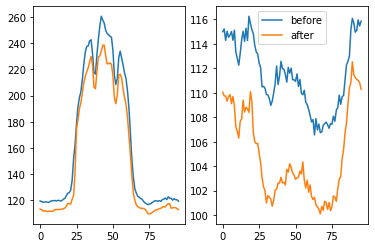

In [152]:
plt.subplot(1,2,1)
plt.plot(weekDayModel_avg1)
plt.plot(weekDayModel_avg2)

plt.subplot(1,2,2)

plt.plot(otherModel_avg1,label='before')
plt.plot(otherModel_avg2,label='after')
plt.legend()

In [153]:
# np.where(train.index=='2019-03-01 00:00:00')

In [154]:
#train.iloc[37252]
len(train.iloc[68936:])

19776

In [155]:
# use last week of training for validation
